In [1]:
Pkg.add("PyPlot");
Pkg.build("PyPlot");
using PyPlot;

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of PyPlot
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Building PyCall
INFO: PyCall is using /usr/bin/python (Python 2.7.6) at /usr/bin/python, libpython = libpython2.7
INFO: Recompiling stale cache file /home/juser/.julia/lib/v0.4/PyCall.ji for module PyCall.
INFO: Recompiling stale cache file /home/juser/.julia/lib/v0.4/PyPlot.ji for module PyPlot.


In [2]:
Pkg.clone("https://github.com/mpf/Toms566.jl.git");

INFO: Cloning Toms566 from https://github.com/mpf/Toms566.jl.git


LoadError: LoadError: Toms566 already exists
while loading In[2], in expression starting on line 1

In [3]:
Pkg.test("Toms566");

INFO: Testing Toms566


No.  Name                             n        f(x0)     |∇f(x0)| cond(∇²f(x0))
  

INFO: Toms566 tests passed


1  Hellical valley                  3     2.50e+03     1.88e+03     9.82e+00
  2  Bigg's EXP6                      6     7.79e-01     2.55e+00     1.30e+01
  3  Gaussian                         3     3.89e-06     7.45e-03     5.10e+01
  4  Powell                           2     1.14e+00     2.00e+04     1.37e+08
  5  Box 3-dim                        3     1.03e+03     1.49e+02     1.19e+02
  6  Variably dimensioned            40     9.39e+10     1.01e+11     1.65e+04
  7  Watson                           9     3.00e+01     1.78e+02     1.63e+02
  8  Penalty I                       60     5.45e+09     8.02e+07     4.24e+00
  9  Penalty II                      65     2.87e+05     3.28e+05     9.84e+01
 10  Brown badly scaled               2     1.00e+12     2.00e+06     1.00e+00
 11  Brown and Denis                  4     7.93e+06     2.14e+06     6.93e+02
 12  Gulf research and development    3     1.21e+01     3.97e+01     4.65e+04
 13  Trigonometric                   40     2.01e-03  

In [4]:
using Toms566;

In [5]:
function warmup(warmUp, obj, x, its, fvals, gNormVals)
    for i = 1:warmUp
        (f,g,H) = obj(x);
        (sigma, V) = eig(H)
        L = maximum(sigma)
        x = x - (1/L)*g

        its = its + 1;
        fvals = [fvals; f];
        gNormVals = [gNormVals; norm(g,2)];
    end
    return (x,its,fvals,gNormVals)
end

warmup (generic function with 1 method)

In [6]:
function newtstep1(x,its,fvals,gNormVals)
    (f,g,H) = obj(x);
        
    #modify H if not pos def
    E = eigfact(H);
    V = E[:vectors];
    lambda = diagm(max(abs(E[:values]),1e-2));
    d = -V*inv(lambda)*transpose(V)*g;
        
    #backtracking linesearch
    alpha = 1;
    mu = 10^-2.0;
    (newf,newg,newH) = obj(x+alpha*d);
    while newf > f + (alpha*mu)*(dot(g,d))
        (newf, newg, newH) = obj(x + alpha*d);
        alpha = alpha/2;
    end

    x = x+alpha*d;

    its = its + 1;
    fvals = [fvals; f];
    gNormVals= [gNormVals; norm(g,2)];
    return(x,g,its,fvals,gNormVals);
end

newtstep1 (generic function with 1 method)

In [7]:
function newtstep2(x,its,fvals,gNormVals)
    (f,g,H) = obj(x);
        
    #modify H if not pos def
    E = eigfact(H);
    V = E[:vectors];
    lambda = diagm(max(E[:values],1e-2));
    d = -V*inv(lambda)*transpose(V)*g;
        
    #backtracking linesearch
    alpha = 1;
    mu = 10^-2.0;
    (newf,newg,newH) = obj(x+alpha*d);
    while newf > f + (alpha*mu)*(dot(g,d))
        (newf, newg, newH) = obj(x + alpha*d);
        alpha = alpha/2;
    end

    x = x+alpha*d;

    its = its + 1;
    fvals = [fvals; f];
    gNormVals= [gNormVals; norm(g,2)];
    return(x,g,its,fvals,gNormVals);
end

newtstep2 (generic function with 1 method)

In [8]:
function Or(boolArray)
    for i=1:size(boolArray,1)
        if boolArray[i] == true
            return (true, i)
        end
    end
    return (false,size(boolArray,1))
end

Or (generic function with 1 method)

In [9]:
function newtmin(obj, x0, maxIts, optTol, warmUp, whileSwitch, randPerts,newtVers)
    fvals = [];
    gNormVals=[];
    (f0,g0,H0) = obj(x0);
    x = x0;
    (f,g,H) = obj(x);
    its = 0;
    

    if warmUp > 0
        (x,its,fvals,gNormVals) = warmup(warmUp,obj,x,its,fvals,gNormVals);
    end
    
    while (norm(g,2) > optTol*whileSwitch*norm(g0,2) && norm(g,2) > 1e-8 && its < maxIts)
        if newtVers == 1
            (x,g,its,fvals,gNormVals) = newtstep1(x,its,fvals,gNormVals);
        else
            (x,g,its,fvals,gNormVals) = newtstep2(x,its,fvals,gNormVals);
        end
    end 
    
    if norm(g,2) < optTol*whileSwitch*norm(g0,2) || norm(g,2) < 1e-8
        println("Method computed optimal x: ", x)
        println("\nIterations: ", its)
        println("\nObjective: ", f)
        println("\nInitial gradient norm: ", norm(g0,2))
        println("\nGradient norm: ", norm(g,2))
        return (x, its, fvals, gNormVals)
    else
        perts = 0;
        while perts < randPerts
            E = eigfact(H);
            lambda = E[:values];
            V = E[:vectors];
            if Or(lambda.<0)[1]
                perts = perts + 1
                x = x + optTol*V[Or(lambda.<0)[2]];         #use small perturbation in decreasing eigenvector direction
                while (norm(g,2) > optTol*whileSwitch*norm(g0,2) && norm(g,2) > 1e-8 && its < (perts + 1)*maxIts)
                    (x,g,its,fvals,gNormVals) = newtstep1(x,its,fvals,gNormVals);
                end 
            end
            if norm(g,2) < optTol*whileSwitch*norm(g0,2) || norm(g,2) < 1e-8
                println("Method computed optimal x: ", x)
                println("\nIterations: ", its)
                println("\nObjective: ", f)
                println("\nInitial gradient norm: ", norm(g0,2))
                println("\nGradient norm: ", norm(g,2))
                return (x, its, fvals, gNormVals)
            end
        end
        println("Method timed out on maxIts: ", its)
        println("\nx: ", x)
        println("\nObjective: ", f)
        println("\nInitial gradient norm: ", norm(g0,2))
        println("\nGradient norm: ", norm(g,2))
    end
    return (x, its, fvals, gNormVals);
end

newtmin (generic function with 1 method)

Method computed optimal x: 

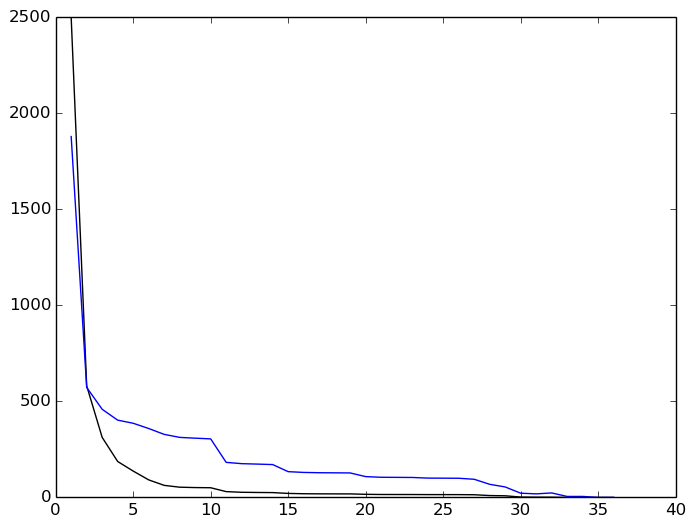

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1a8459be10>

[1.000000000000102,1.0511178075666133e-12,1.6937368340670536e-12]

Iterations: 36

Objective: 2500.0

Initial gradient norm: 1879.6354942005228

Gradient norm: 1.8056448901281196e-5


In [10]:
p = Problem(1);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,0,6,1);
plot(1:size(fvals,1),fvals, "k")
plot(1:size(gNormVals,1),gNormVals)

Method timed out on maxIts: 7000

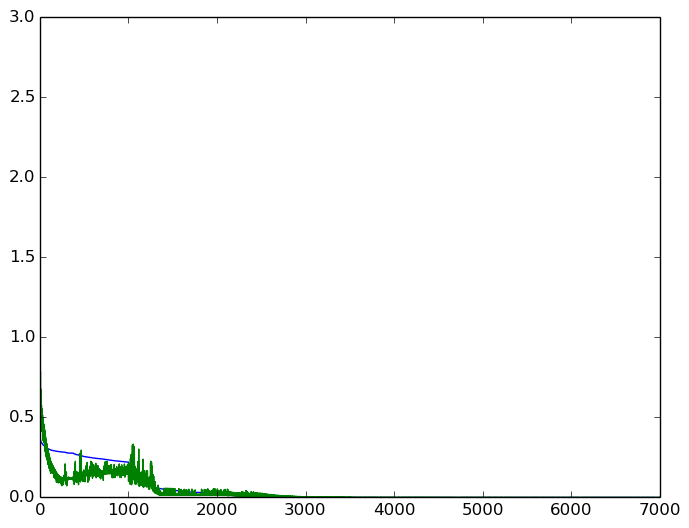

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1a843dfcd0>

In [11]:
p = Problem(2);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,2);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)



x: [4.410753644328361,9.9349136210942,3.067349161602675,5.282082534640079,1.1190801975404232,1.1838292824421812]

Objective: 0.7790700756559702

Initial gradient norm: 2.553901364141021

Gradient norm: 0.0004319335009026329
Method computed optimal x: 

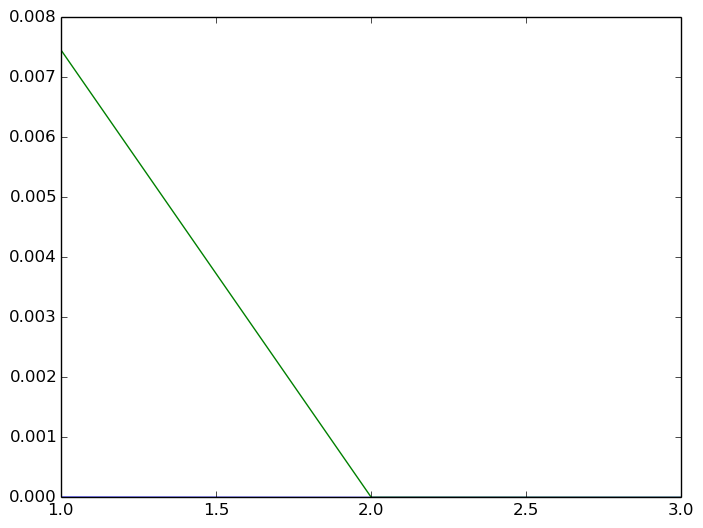

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1a84324b50>

In [12]:
p = Problem(3);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,2);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

[0.3989561378387567,1.0000190844878059,6.906301132243387e-20]

Iterations: 3

Objective: 3.888106991166885e-6

Initial gradient norm: 0.007451532810877683

Gradient norm: 9.701953934166454e-11
Method computed optimal x: 

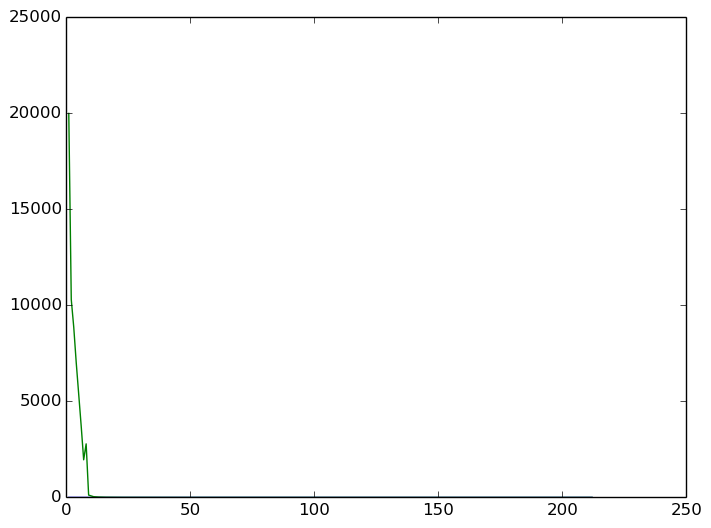

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1a8425c7d0>

In [13]:
p = Problem(4);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,2);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

[1.767323536778054e-5,5.658272889153817]

Iterations: 212

Objective: 1.1352617173483783

Initial gradient norm: 20000.73556071284

Gradient norm: 0.019904000738054105
Method computed optimal x: 

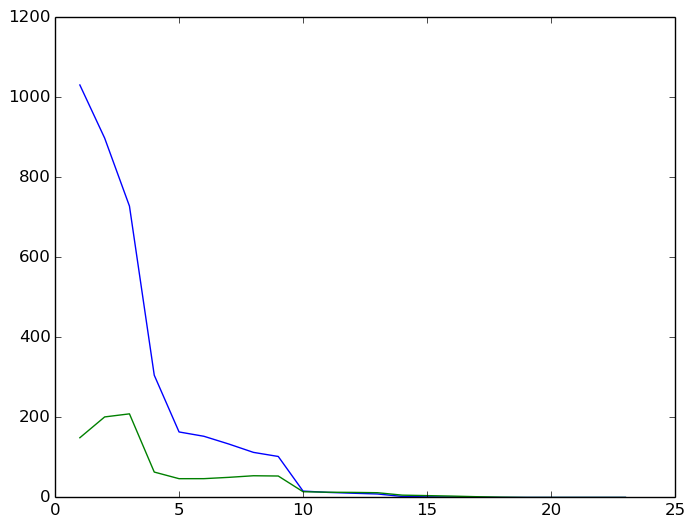

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1a841f8a90>

In [14]:
p = Problem(5);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,2);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

[2.8303743431436907,2.809562677606822,-0.003818908495510345]

Iterations: 23

Objective: 1031.1538106093983

Initial gradient norm: 149.27637392602293

Gradient norm: 0.00011291457396812219
Method computed optimal x: 

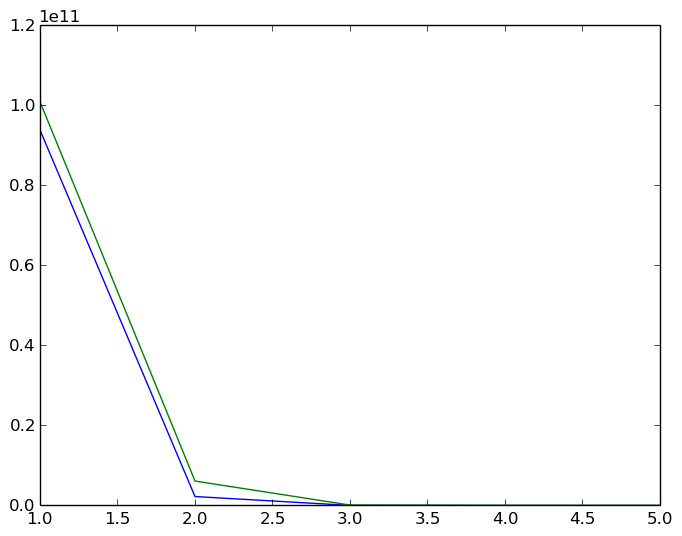

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1a841277d0>

In [15]:
p = Problem(6);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,2);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

Method timed out on maxIts: 10000

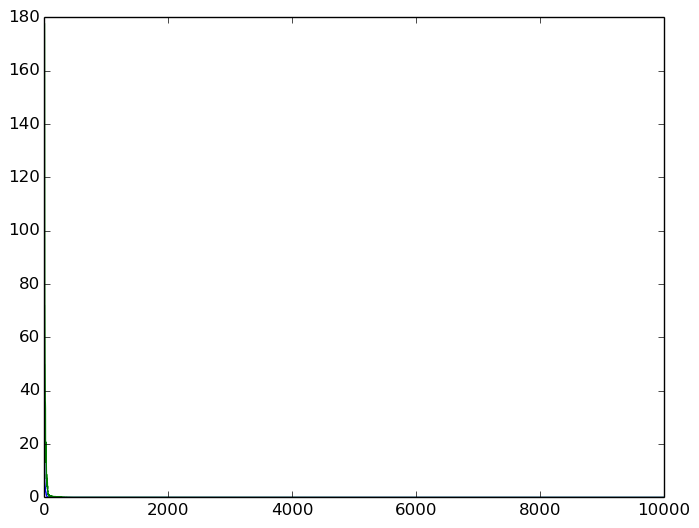

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f51b906fd50>



x: [0.0002353354085099133,0.9954371368989143,0.0675786305669077,0.07848961952874674,0.3165971715919962,0.12851678243090817,-0.07256242285588412,-0.23474160153848111,0.2789956441986791]

Objective: 30.0

Initial gradient norm: 177.57910434783236

Gradient norm: 0.0005522926273691033


In [37]:
p = Problem(7);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,9,1);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)



x: [-0.004305587288438634,1.0112483572111663,0.1313690418594913,-1.3201581913548983,4.64751627894377,-3.2259780992036453,-3.952711856946365,6.743651234185034,-2.4879808488077186]

Objective: 30.0

Initial gradient norm: 177.57910434783236

Gradient norm: 0.010700679070808366
Method computed optimal x: 

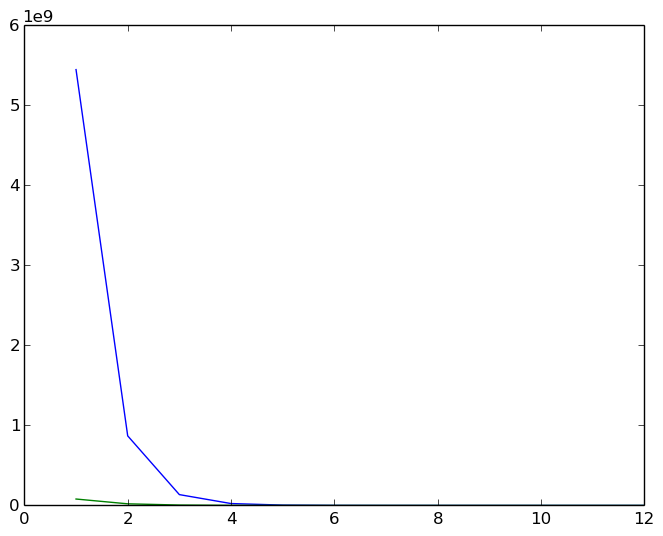

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1a7dfb9550>

[0.22938267106491705,0.23161632219908515,0.23179541585581637,0.23214770674764695,0.23180978163574043,0.23229376821836029,0.23210685469695966,0.23190773182332947,0.23295758015931164,0.23287204233904496,0.2332924970835784,0.23276533845803338,0.23357679688806027,0.23290754671925193,0.23351314089010006,0.23285458931401998,0.23275896642196592,0.23334969680181122,0.23320389522535429,0.2329697406956864,0.2334234037625143,0.2326497510487456,0.23285233512352926,0.23309664388744034,0.23316146755837394,0.23297509839683833,0.23308961582551402,0.2333382309925351,0.23246907778453826,0.23293521714506266,0.23342351008017634,0.2332734975000855,0.23356888933723807,0.23341989718895087,0.23351078282705218,0.2333309361998386,0.23377193987767636,0.23353857988389637,0.23314613603463133,0.23355785185145084,0.23326397580399427,0.233158046604786,0.23355507763211764,0.2333004303333321,0.23308843329696613,0.23371612531206903,0.23322949513481211,0.23357223136017097,0.23299811978525425,0.23322190080998695,0.2332652

In [17]:
p = Problem(8);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,2);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

Method computed optimal x: 

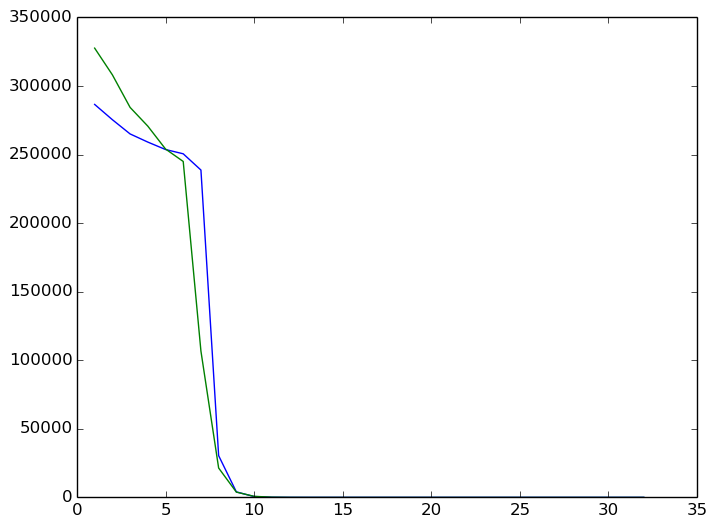

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1a7ded3c10>

[0.01117148593621167,3.153171753940753e-6,5.93984697341078e-7,1.5617449539142451e-7,1.1702449306323542e-5,2.8882300320214346e-7,3.0695069929813683e-7,-3.091967120614551e-7,5.985347675991975e-7,9.081988111564121e-7,6.195890762724825e-7,6.963504132050004e-7,8.510764021949491e-6,1.0403353827860642e-6,1.5105743878673481e-6,6.998344631502082e-6,5.314780728064938e-6,6.8811839483477215e-6,1.7841187175384557e-6,-6.402875926604024e-5,2.042608595205307e-5,-8.767786707126716e-6,4.320880187330142e-6,4.740319352455345e-6,3.291835129983622e-6,0.00013998673199586685,8.985843420759842e-5,9.011322173459608e-6,9.992548544329473e-6,-3.382810651731952e-6,2.5076025837147284e-5,-0.0008913324911209102,2.1195497819523288e-5,1.5739843156052907e-5,4.520404520218156e-5,2.923294859026542e-5,0.0001659502154726963,6.857340786981051e-5,4.7173986793624567e-5,-3.5045930449973403e-5,4.375248911207571e-5,0.00016637607250681688,5.523301655599019e-5,9.619953125762724e-5,0.0009422350156109174,0.00025300064382067263,0.00011

In [18]:
p = Problem(9);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,2);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

Method computed optimal x: 

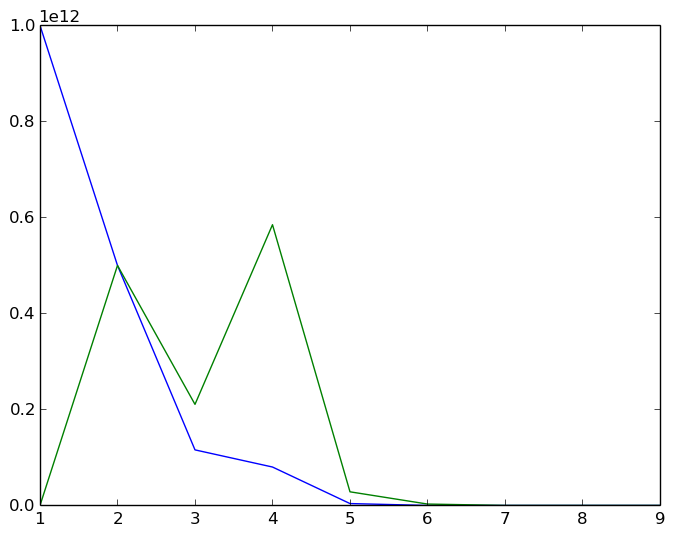

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1a7de20210>

In [19]:
p = Problem(10);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,2);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

Method computed optimal x: 

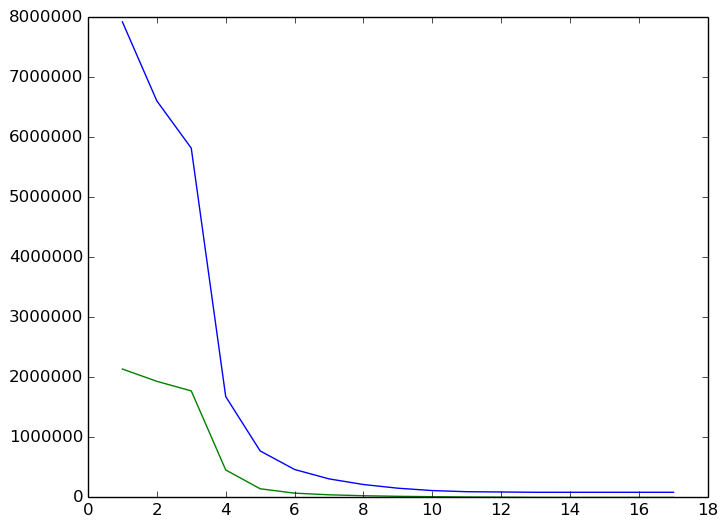

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f51b97ef590>

[-11.594378842297063,13.203610367000444,-0.4034248057723377,0.2366111959994655]

Iterations: 17

Objective: 7.926693336997432e6

Initial gradient norm: 2.1404906724316664e6

Gradient norm: 1.194451595747618


In [26]:
p = Problem(11);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,1);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

Method computed optimal x: 

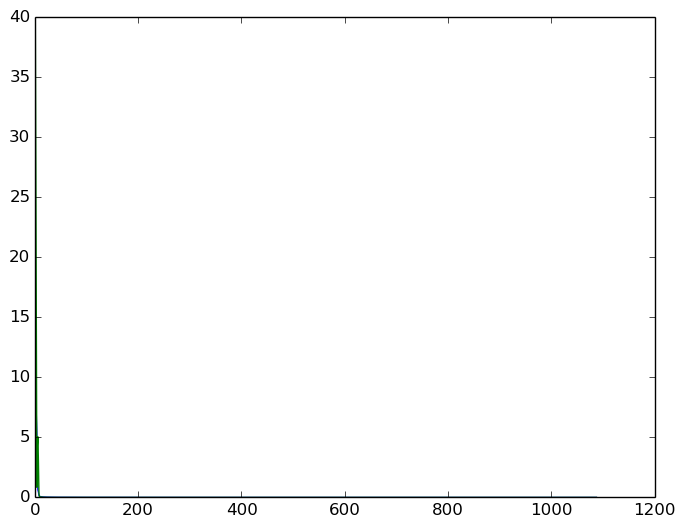

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f51b95a2c90>

[47.42336787114602,25.091189792714314,1.4837918315087462]

Iterations: 1087

Objective: 12.11070582556949

Initial gradient norm: 39.731596914010105

Gradient norm: 3.971119684078704e-5


In [30]:
p = Problem(12);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,1);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

Method computed optimal x: 

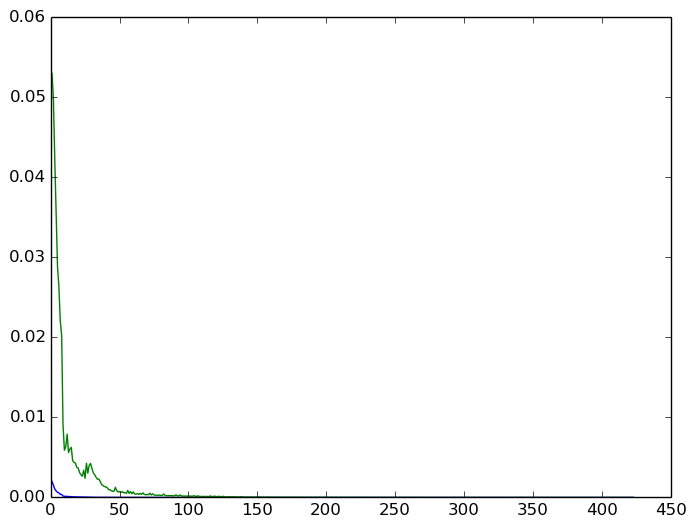

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f51b94e5550>

[0.01363078355275441,0.013725448005454931,0.013822799938139969,0.013922987029800327,0.01402616677398562,0.014132511126326358,0.014242211018097254,0.014355462118315176,0.014472502704144772,0.014593572703439686,0.014718944831165372,0.014848897430767697,0.014983772786169209,0.015123960934729255,0.015269810667337454,0.015421833979682789,0.015580611932116082,0.01574655346281645,0.01592045353831438,0.0161030626419362,0.01629519535087839,0.01649796431570018,0.01671242886499599,0.06565621439501441,0.017182549044906105,0.01744179873447974,0.055515427752085726,0.05251067363740267,0.018347657890266555,0.04688035221040968,0.04418557534427524,0.04150564187544001,0.03874173099102514,0.02059120312189405,0.021234192405108966,0.021964369563558257,0.022733351440640103,0.023349301431687182,0.023595062217317907,0.02351244720163554]

Iterations: 423

Objective: 0.0020050158027922703

Initial gradient norm: 0.053004878349026306

Gradient norm: 5.013323889939271e-8


In [31]:
p = Problem(13);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,1);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

Method timed out on maxIts: 7000

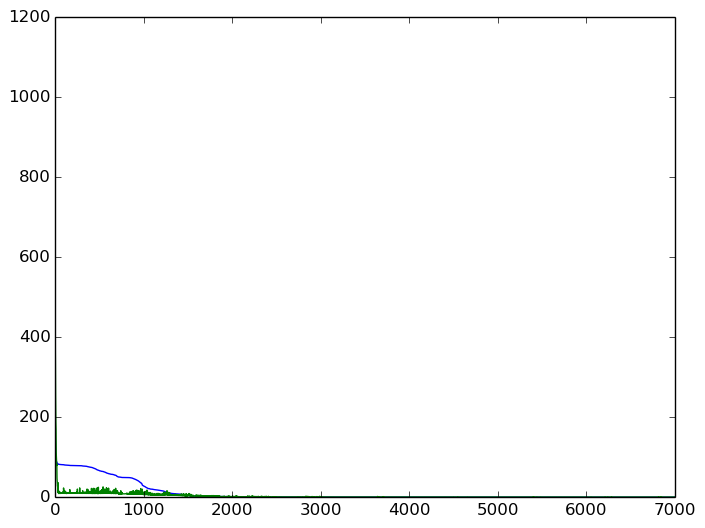

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f51b9428050>



x: [0.6419625848360674,0.41036130378502955,0.8212427564388485,0.6736763329070401,0.9315484494132941,0.8676415395441506,0.6685880416993308,0.4453604037028643,0.8103085618183874,0.6559173460132915,0.8244088910070537,0.6785995924012183,0.8340602966796246,0.6950201376211226,0.7046337576852822,0.4948863231995735,0.949567937151934,0.9014251917606647,0.8268036934182036,0.682494407351014,0.8567150115707445,0.7335428378330479,0.9300246051813945,0.8646058431071549,0.9355425951714985,0.8752248168550799,0.8831610328226598,0.7794780469366905,0.7859066782020077,0.6171307073757657,0.7341488118637708,0.5374621182065118,0.8567150115661967,0.7335428378252407,0.8567150115661967,0.7335428378252407,0.8567150115661967,0.7335428378252407,1.0,1.0]

Objective: 483.99999999999983

Initial gradient norm: 1041.4159591632922

Gradient norm: 1.014878164768672


In [32]:
p = Problem(14);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,1);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

Method timed out on maxIts: 7000

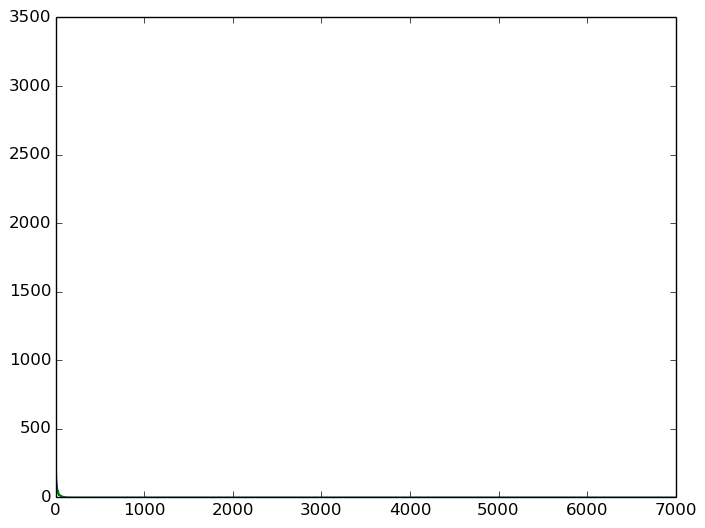

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f51b935ded0>



x: [0.1171244125774352,-0.011698756903213666,0.05566388555036883,0.05666572764403077,0.0626548008481316,-0.006264702457331703,0.043491357072192316,0.043806229951668114,0.06181782307672703,-0.006201153657969748,0.03827655179602136,0.03815256988334078,-0.07902812615307996,0.007925588741188856,-0.048505164336239366,-0.04914444208142717,0.031014905202215056,-0.0031225702133931264,0.00717803835401292,0.00709961604374901,0.02346209324036668,-0.002352726582184509,-0.0019713528970764617,-0.0020944656161392436,0.07485872095901891,-0.007488588709733078,0.04972014259095725,0.04996830467572931,0.09833269790319486,-0.009858047362271942,0.047074716470824916,0.0477853447033989,0.06521768876285075,-0.0065452459452467505,0.0357564836216784,0.03599660689501017,0.0635462149647647,-0.0063614403921688645,0.04034643409976214,0.04041579479238116,0.07315360571897754,-0.007321772844302376,0.04702825983974184,0.0472738196773972,0.11827769470385288,-0.011808106235765382,0.058989775557894385,0.06049034072561176

In [33]:
p = Problem(15);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,1);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

Method computed optimal x: 

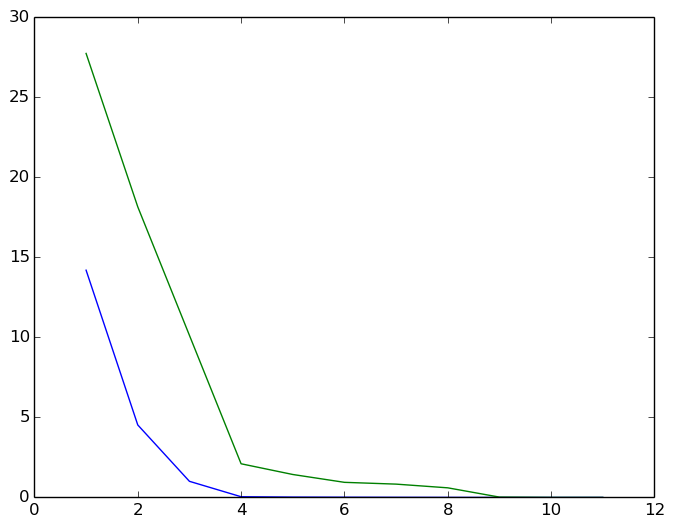

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f51b9b63a50>

[2.999999999999923,0.49999999999998906]

Iterations: 11

Objective: 14.203125

Initial gradient norm: 27.75

Gradient norm: 1.883514309060696e-7


In [21]:
p = Problem(16);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,2);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

Method computed optimal x: 

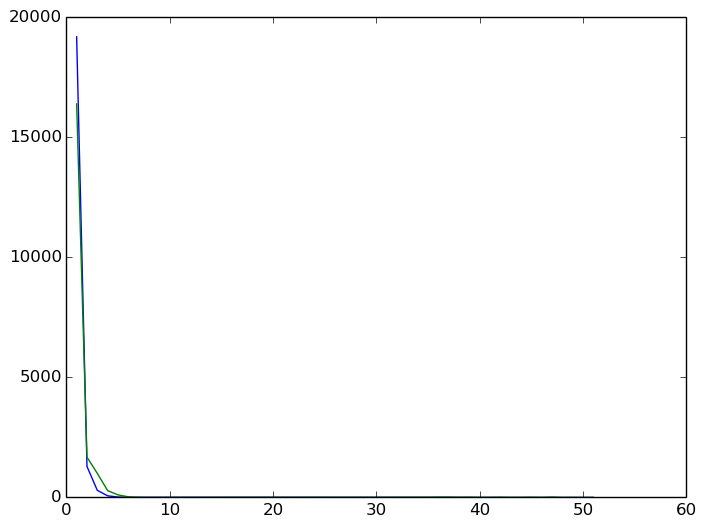

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f51b9a92350>

[0.9999999986082352,0.9999999972052892,1.0000000014404364,1.000000002829045]

Iterations: 51

Objective: 19192.0

Initial gradient norm: 16397.125601763255

Gradient norm: 0.0015865406090950793


In [22]:
p = Problem(17);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,2);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

Method timed out on maxIts: 7000

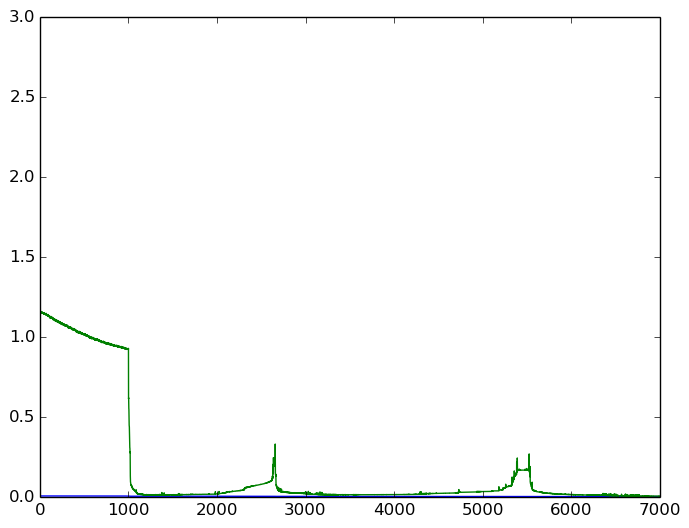

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f51b98ba350>



x: [0.017084315048177177,0.032743405397639536,0.053169973533454755,0.07346029989955648,0.09320109513025471,0.11259351047761938,0.13379152345983714,0.1506948620962062,0.17648954771278874,0.18720127953547194,0.22031985434557014,0.22443695004385977,0.2552053950363008,0.2720612672837646,0.2892751436031632,0.31459050262077715,0.3316223784183362,0.3480648542723688,0.37718207594792635,0.3874282381697626,0.4095792071213677,0.4362569593174569,0.44651635044043586,0.4704188119847145,0.4925899006649628,0.5100097300684822,0.5271194288835052,0.5549177217897739,0.5667376454938133,0.5880946367318275,0.6135579694555,0.6261261172023472,0.6484935583365908,0.6718994625747817,0.6857650332462564,0.7091125785710335,0.7295957950547631,0.7461638887955352,0.7693038500600033,0.787399110611615,0.8069863326202096,0.8284787852785244,0.8460248797020841,0.8679467042095231,0.886049204064069,0.9072292759727024,0.9260799539203363,0.9476430056858504,0.9685731419214421,0.9837734453402548]

Objective: 0.01394836159928867

In [25]:
p = Problem(18);
x0 = p.x0;
function obj(x)
    return (p.obj(x),p.grd(x),p.hes(x));
end
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,2);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)

Method computed optimal x: 

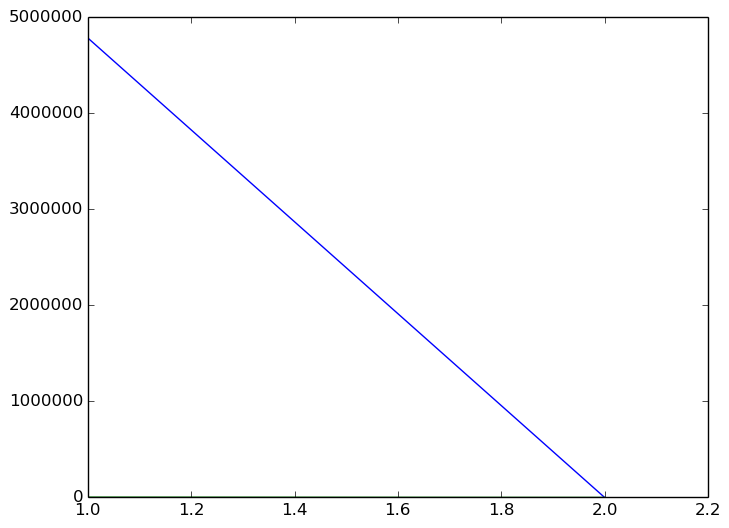

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd47c246e10>

[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]

Iterations: 2

Objective: 4.785078960084721e6

Initial gradient norm: 3093.5671837167915

Gradient norm: 0.0


In [10]:
function obj(x)                                          #Simple test quadratic
    return((1/2)*dot(x,x), x, eye(size(x,1)))
end

x0 = 1000*randn(10);
(x,its,fvals,gNormVals) = newtmin(obj,x0,1000, 1e-6, 0,1,6,2);
plot(1:size(fvals,1),fvals)
plot(1:size(gNormVals,1),gNormVals)